In [2]:
from mech_module import *
from arima_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
rivers = {'Brahmaputra, BD': 'DATA/2651100_Q_Day.Cmd.txt',
            'Tista, BD': 'DATA/2651080_Q_Day.Cmd.txt', 
            'Tadi Khola, NP': 'DATA/2549220_Q_Day.Cmd.txt',
            'Chepe Khola, NP': 'DATA/2549230_Q_Day.Cmd.txt',
            'Ganges, BD': 'DATA/2646200_Q_Day.Cmd.txt',
            'Chindwin, MM': 'DATA/2260100_Q_Day.Cmd.txt',
            'Irrawaddy, MM': 'DATA/2260400_Q_Day.Cmd.txt',
            'Sittang, MM': 'DATA/2261500_Q_Day.Cmd.txt',}


# Long term power prediction at a location

This notebook will combine the ARIMA time series forecasting at a location and the main power calculation. The output will be average daily power generation at a location for a year. This time series will be used to calculate minimum, maximum and average power as well as the total power.

1. Import data, fit ARIMA model and forecast power generation at a location

0.0035990966267461237


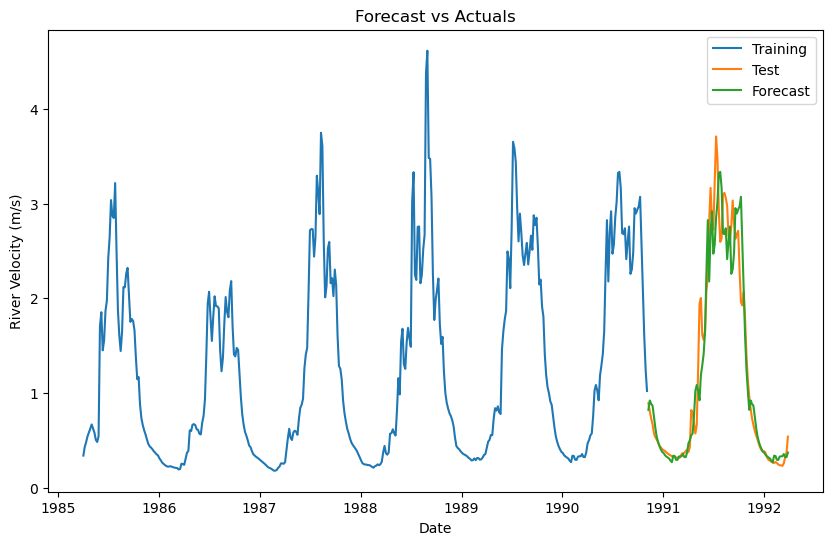

In [4]:
# using data from the ....
file_path = rivers['Brahmaputra, BD']
metadata, data = read_data(file_path)
station_info, parsed_data = process_data(metadata, data)

lat1 = station_info['Latitude (DD)']
long1 = station_info['Longitude (DD)']
# find maximum slope within 1 km
lat1 = float(lat1) + 0.01
long1 = float(long1) 
lat2 = lat1 - 0.01
long2 = long1 
dist = np.sqrt((lat1 - lat2)**2 + (long1 - long2)**2 ) * 111139
# upstream = get_elevation(25.203444,89.686458) - manual for Bangladesh
# downstream = get_elevation(25.172212, 89.662100) 
upstream = get_elevation(lat1, long1)
downstream = get_elevation(lat2, long2)
slope = (downstream - upstream)/dist # 1140 is the distance between the two points in meters
print(slope)
Q = parsed_data['Value'].mean() # average discharge m^3/s
W = 1200 # width in meters
S = slope # slope at location
D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters
parsed_data['Velocity'] = parsed_data['Value'] / (W * D) # velocity in m/s
parsed_data = downsample(parsed_data)
train, test = split_data(parsed_data, split=0.8)
model = arima_model(train, order=(2,0,2), seasonal_order=(0,1,0,73))
forecast_data = forecast(model, test)
plt.figure(figsize=(10,6))
plt.plot(train.dropna(),  label='Training')
plt.plot(test.dropna(), label='Test')
plt.plot(forecast_data, label='Forecast')
plt.title('Forecast vs Actuals')
plt.ylabel('River Velocity (m/s)')
plt.xlabel('Date')
plt.legend()
plt.show()

2. Calculate daily power generation at a location.

Need to upsample the time series to daily frequency and calculate average power generation at a location for a year.

--------------Average Power--------------
Average Power (W): 192.060115264218
--------------Energy Output--------------
Daily Energy Output (kWh): 4.609442766341233
Monthly Energy Output (kWh): 138.28328299023698
Yearly Energy Output (kWh): 1682.44660971455
--------------Peak Season (P > 100W)--------------
Average Power (W) during peak season: 603.8646481570028
--------------Energy Output--------------
Daily Energy Output (kWh) during peak season: 14.492751555768066
Monthly Energy Output (kWh) during peak season: 434.782546673042
--------------Comparison--------------
Average household per capita of around 497 kWh per year in BD (2021)


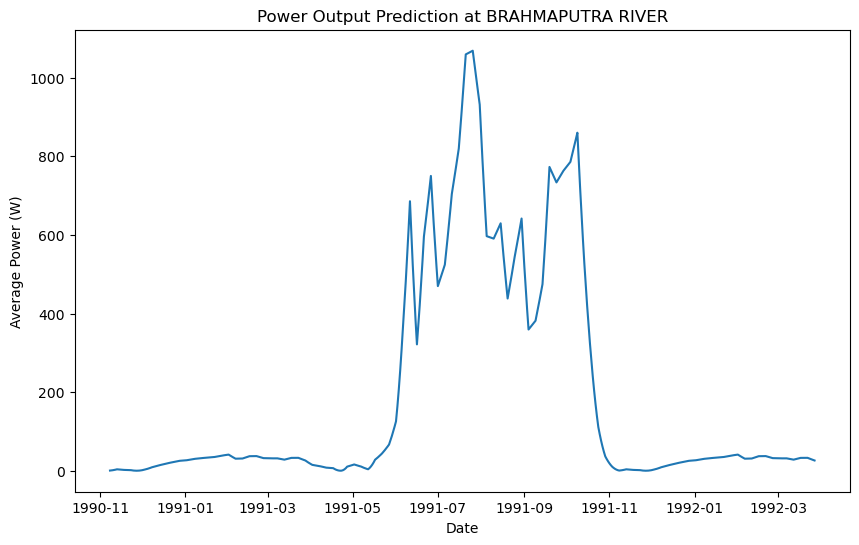

In [5]:
# upsample forecast data
full_forecast_data = forecast_data.resample('D').mean()
full_forecast_data = full_forecast_data.interpolate(method='linear')
### calculate daily power output
# turbine parameters
turbine_width = 1.2
turbine_diameter = 1.2
r_drum = 0.425
pontoon_grid_multiplier = 1.15 # found in main.ipynb
generator_eff = 0.9
gearbox_eff = 0.95
efficiency = generator_eff * gearbox_eff

# calculate power output
shaft_power = power(full_forecast_data * pontoon_grid_multiplier, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=20) * efficiency

# plot power output
plt.figure(figsize=(10,6))
plt.plot(shaft_power)
plt.title('Power Output Prediction at %s' %(station_info['River']))
plt.xlabel('Date')
plt.ylabel('Average Power (W)')


# calculate the daily, monthly, and yearly energy output as the mean of the power output in that timeframe
# shaft power is given as avg W each day 
daily_energy = shaft_power.mean()*24/1000
monthly_energy = shaft_power.mean()*24*30/1000 
yearly_energy = shaft_power.mean()*24*365/1000

print('--------------Average Power--------------')
print(f"Average Power (W): {shaft_power.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh): {daily_energy}")
print(f"Monthly Energy Output (kWh): {monthly_energy}")
print(f"Yearly Energy Output (kWh): {yearly_energy}")

# calculate the same values but during peak season (when p > 100W)
peak_season = shaft_power[shaft_power > 100]
daily_energy_peak = peak_season.mean()*24/1000
monthly_energy_peak = peak_season.mean()*24*30/1000
yearly_energy_peak = peak_season.mean()*24*365/1000

print('--------------Peak Season (P > 100W)--------------')
print(f"Average Power (W) during peak season: {peak_season.mean()}")
print('--------------Energy Output--------------')
print(f"Daily Energy Output (kWh) during peak season: {daily_energy_peak}")
print(f"Monthly Energy Output (kWh) during peak season: {monthly_energy_peak}")
# print(f"Yearly Energy Output (kWh) during peak season: {yearly_energy_peak}")

print('--------------Comparison--------------')
print('Average household per capita of around 497 kWh per year in BD (2021)') # https://www.enerdata.net/estore/energy-market/bangladesh/#:~:text=Energy%20consumption%20per%20capita%20is,average%20in%20the%20same%20period).


plt.show()

